In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!tar -xf "/content/drive/My Drive/Colab Notebooks/Speculo/dataset.tar.gz"

In [0]:
# %tensorflow_version 2.x
from PIL import Image
import os
import numpy as np
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, \
    MaxPooling2D, BatchNormalization, Flatten, Reshape, Activation, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model


class Speculo:
    def __init__(self, image_size=(128, 128, 1), model_path="models/v5-adam-mae.h5", visualize=True):
        self.optimizer = 'adam'
        self.loss_function = 'mse'
        self.LR = 1e-3

        self.filters = (256, 128, 64)
        self.latent_size = 350

        self.image_size = image_size
        self.model_path = model_path
        self.visualize = visualize

        # model_number = 1
        # if os.path.isdir("logs"):
        #     model_number += len(os.listdir("logs/"))

        self.model_number = 3

        self.model = None

    def _build_model(self):
        if self.image_size[2] == 1:
            input_img = Input(shape=self.image_size, name="input")
        else:
            input_img = Input(shape=self.image_size, name="input")
        x = input_img

        for f in self.filters:
            x = Conv2D(f, (3, 3), activation='relu', padding='same')(x)
            x = MaxPooling2D((2, 2))(x)
            x = Dropout(0.1)(x)

        size = K.int_shape(x)
        x = Flatten()(x)
        x = Dropout(0.2)(x)
        x = Dense(self.latent_size, name="latent_space")(x)

        x = Dense(np.prod(size[1:]))(x)
        x = Reshape((size[1], size[2], size[3]))(x)

        for f in self.filters[::-1]:
            x = Conv2DTranspose(f, (3, 3), strides=2, activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Dropout(0.1)(x)

        x = Conv2DTranspose(self.image_size[2], (3, 3), activation='relu', padding='same')(x)
        output = Activation("sigmoid", name="output")(x)

        return Model(inputs=input_img, outputs=output, name=f"Speculo-v{self.model_number}")

    def autoencoder(self):
        autoencoder = self._build_model()
        autoencoder.compile(optimizer=self.optimizer, loss=self.loss_function)
        return autoencoder

    def read_image(self, file):
        im = Image.open(file)
        im = im.resize(self.image_size[:2], Image.ANTIALIAS)
        if self.image_size[2] == 1:
            im = im.convert('L')
        return np.array(im)

    def _load_image_set(self, directory, noise_factors=None):
        x, y = [], []
        fronts = sorted(os.listdir(f"dataset/{directory}/Front/"))
        for i, person_dir in enumerate(sorted(os.listdir(f"dataset/{directory}"))):
            if person_dir == "Front":
                continue
            else:
                y_image = self.read_image(f"dataset/{directory}/Front/{fronts[i - 1]}")
                for image in os.listdir(f"dataset/{directory}/{person_dir}"):
                    x_image = self.read_image(f"dataset/{directory}/{person_dir}/{image}")
                    x.append(np.array(x_image))
                    y.append(np.array(y_image))

        x = np.array(x).astype("float32") / 255.0
        y = np.array(y).astype("float32") / 255.0
        if self.image_size[2] == 1:
            x = x.reshape([-1, self.image_size[0], self.image_size[1]])
            y = y.reshape([-1, self.image_size[0], self.image_size[1]])

        else:
            x = x.reshape([-1, self.image_size[0], self.image_size[1], self.image_size[2]])
            y = y.reshape([-1, self.image_size[0], self.image_size[1], self.image_size[2]])

        if noise_factors:
            noisy_x, noisy_y = [], []
            for noise_factor in noise_factors:
                noisy_x.append(x + (noise_factor / 10) * np.random.normal(loc=0.0, scale=1.0, size=x.shape))
                noisy_y.append(y)

            noisy_x = np.reshape(noisy_x, [-1, self.image_size[0], self.image_size[1], self.image_size[2]])
            noisy_y = np.reshape(noisy_y, [-1, self.image_size[0], self.image_size[1], self.image_size[2]])

            return shuffle(np.clip(noisy_x, 0., 1.), noisy_y)

        return shuffle(x, y)

    def display_image_array(self, n, *image_sets, figsize=(8, 4), title=None, labels=None, save_dir=None):
        plt.figure(figsize=figsize)
        if title:
            plt.suptitle(title)
        i = 1
        row = 0
        if labels and len(labels) != len(image_sets):
            labels = None
        for image_set in image_sets:
            for x in range(n):
                ax = plt.subplot(len(image_sets), n, i)
                if x == 0 and labels:
                    ax.set_title(labels[row])
                if self.image_size[2] == 1:
                    plt.imshow(image_set[x].reshape(self.image_size[:2]))
                    plt.gray()
                else:
                    plt.imshow(image_set[x].reshape(self.image_size))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                i += 1
            row += 1
        if save_dir:
            plt.savefig(save_dir)
        plt.show()

    def _create_dataset(self):
        x_train, y_train = self._load_image_set("train", noise_factors=(0.3, 0.6, 0.9, 1))
        x_test, y_test = self._load_image_set("test", noise_factors=(0.3, 0.6))
        if self.visualize:
            self.display_image_array(10, x_train, y_train, x_test, y_test,
                                     title=f"Dataset ({len(x_train) + len(x_test)})",
                                     labels=["x_train", "y_train", "x_test", "y_test"],
                                     save_dir=f'models/{self.model_number}/img/dataset.png')
        return x_train, y_train, x_test, y_test

    def train(self):
        if os.path.exists(f"models/{self.model_number}"):
            raise FileExistsError(f"models/{self.model_number} already existing")
        os.makedirs(f"models/{self.model_number}/img")

        x_train, y_train, x_test, y_test = self._create_dataset()
        self.model = self.autoencoder()

        plot_model(self.model, to_file=f'models/{self.model_number}/img/model.png')

        with open(f"models/{self.model_number}/README.md", "w") as f:
            f.write(f"# Model v{self.model_number}\n")
            f.write(f"Optimizer - {self.optimizer} (LR - {self.LR}) <br>\n")
            f.write(f"Loss Function - {self.loss_function} <br>\n")
            f.write(f"Input Shape - {self.image_size} <br>\n")
            f.write(f"Filters - {self.filters} <br>\n")
            f.write(f"Latent Size - {self.latent_size} <br>\n\n")
            if self.visualize:
                f.write("### Dataset Sample\n")
                f.write("![DataSet](img/dataset.png)\n\n")
            f.write(f"## Model Summary\n```shell script\n")
            self.model.summary(print_fn=lambda x: f.write(x + '\n'))
            f.write("```\n")
            f.write("![Model](img/model.png)\n\n")
            f.write(f"## Training Log\n```shell script\n\n```\n\n")

        checkpoint = ModelCheckpoint(f"models/{self.model_number}/Model-v{self.model_number}.h5", monitor='loss',
                                     verbose=1, save_best_only=True, mode='min')

        tensorboard = TensorBoard(log_dir=f'logs/Model-v{self.model_number}', histogram_freq=0, write_graph=False)
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')
        history = None
        try:
            history = self.model.fit(x_train, y_train,
                                     epochs=50,
                                     batch_size=64,
                                     shuffle=True,
                                     validation_data=(x_test, y_test),
                                     callbacks=[checkpoint, tensorboard, early_stopping])

            self.model.save(f"models/{self.model_number}/Model-v{self.model_number}-Final.h5")
        except KeyboardInterrupt:
            pass

        finally:
            if history:
                plt.plot(history.history['loss'])
                plt.plot(history.history['val_loss'])
                plt.title('Model loss')
                plt.ylabel('Loss')
                plt.xlabel('Epoch')
                plt.legend(['Train', 'Test'], loc='upper left')
                plt.savefig(f'models/{self.model_number}/img/loss.png')
                plt.show()

            with open(f"models/{self.model_number}/README.md", "a") as f:
                if history:
                    f.write("### Model loss\n")
                    f.write("![loss](img/loss.png)\n\n")
                f.write("## Predictions \n")
                f.write("![loss](img/predictions.png)\n\n")
                f.write("## Notes\n")

            self.evaluate(f'models/{self.model_number}/img/predictions.png')

    def _load_model(self):
        self.model = load_model(self.model_path)
        return self.model

    def _get_latent_space(self):
        autoencoder = self._load_model()
        encoder = Model(inputs=autoencoder.input,
                        outputs=autoencoder.get_layer("latent_space").output)
        self.model = encoder

    def evaluate(self, file=None):
        if self.model is None:
            self._load_model()
        gen_image = []
        org_image = []
        for image in os.listdir("dataset/evaluate"):
            image = self.read_image(os.path.join("dataset/evaluate", image))
            org_image.append(image)
            gen_image.append(self.predict(image))

        self.display_image_array(len(gen_image), org_image, gen_image,
                                 title="Model Predictions", figsize=(8, 2), save_dir=file)

    def predict(self, image, preview=False):
        if self.model is None:
            self._load_model()
        output = self.model.predict(np.reshape(image, [1, self.image_size[0], self.image_size[1], self.image_size[2]]))
        if preview:
            output = (output * 255).astype("uint8")
            return np.reshape(output, self.image_size)
        return output.reshape([-1])

In [13]:
speculo = Speculo()
print(speculo.autoencoder().summary())

Model: "Speculo-v3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 256)     2560      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 64, 256)       0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 32, 32, 128)       0

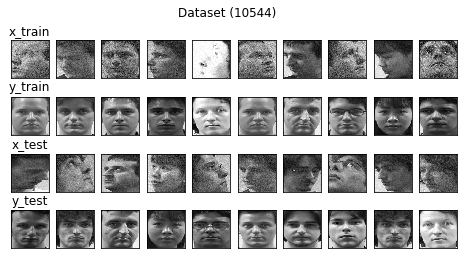

Train on 9992 samples, validate on 552 samples
Epoch 1/50
9984/9992 [============================>.] - ETA: 0s - loss: 0.0358
Epoch 00001: loss improved from inf to 0.03583, saving model to models/3/Model-v3.h5
9992/9992 [==============================] - 258s 26ms/sample - loss: 0.0358 - val_loss: 0.0334
Epoch 2/50
9984/9992 [============================>.] - ETA: 0s - loss: 0.0328
Epoch 00002: loss improved from 0.03583 to 0.03280, saving model to models/3/Model-v3.h5
9992/9992 [==============================] - 250s 25ms/sample - loss: 0.0328 - val_loss: 0.0320
Epoch 3/50
9984/9992 [============================>.] - ETA: 0s - loss: 0.0324
Epoch 00003: loss improved from 0.03280 to 0.03241, saving model to models/3/Model-v3.h5
9992/9992 [==============================] - 250s 25ms/sample - loss: 0.0324 - val_loss: 0.0317
Epoch 4/50
9984/9992 [============================>.] - ETA: 0s - loss: 0.0315
Epoch 00004: loss improved from 0.03241 to 0.03147, saving model to models/3/Model-v3.

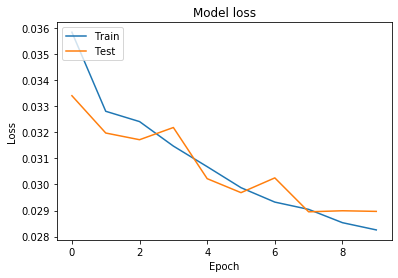

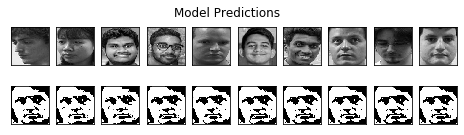

In [17]:
speculo.train()